# XGBoost - direct marketing (Classification)

[Direct Marketing with Amazon SageMaker XGBoost and Hyperparameter Tuning (SageMaker API)](https://sagemaker-examples.readthedocs.io/en/latest/hyperparameter_tuning/xgboost_direct_marketing/hpo_xgboost_direct_marketing_sagemaker_APIs.html)

In [1]:
!pip install xgboost

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import numpy as np
import pandas as pd
import time

In [4]:
!wget -N https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
!unzip -o bank-additional.zip

--2022-10-29 23:45:35--  https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 444572 (434K) [application/x-httpd-php]
Server file no newer than local file ‘bank-additional.zip’ -- not retrieving.

Archive:  bank-additional.zip
  inflating: bank-additional/.DS_Store  
  inflating: __MACOSX/bank-additional/._.DS_Store  
  inflating: bank-additional/.Rhistory  
  inflating: bank-additional/bank-additional-full.csv  
  inflating: bank-additional/bank-additional-names.txt  
  inflating: bank-additional/bank-additional.csv  
  inflating: __MACOSX/._bank-additional  


In [5]:
df = pd.read_csv("./bank-additional/bank-additional-full.csv", sep=";")
pd.set_option("display.max_columns", 500)  # Make sure we can see all of the columns
pd.set_option("display.max_rows", 50)  # Keep the output on one page

In [6]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [7]:
df.isnull().sum().sum()

0

## Wrangling

In [8]:
from sklearn.utils import shuffle
df = shuffle(df, random_state=2)

df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
5485,49,technician,married,basic.9y,no,yes,no,telephone,may,mon,146,6,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4390,56,retired,married,high.school,unknown,no,no,telephone,may,tue,88,2,999,0,nonexistent,1.1,93.994,-36.4,4.856,5191.0,no
38408,70,retired,married,high.school,no,yes,no,cellular,oct,wed,72,3,999,0,nonexistent,-3.4,92.431,-26.9,0.735,5017.5,no
9975,40,blue-collar,married,basic.4y,unknown,no,no,telephone,jun,wed,105,3,999,0,nonexistent,1.4,94.465,-41.8,4.959,5228.1,no
5331,39,blue-collar,married,basic.9y,no,yes,no,telephone,may,fri,83,2,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [9]:
df = df.drop(['duration', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed'], axis=1)
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,y
5485,49,technician,married,basic.9y,no,yes,no,telephone,may,mon,6,999,0,nonexistent,no
4390,56,retired,married,high.school,unknown,no,no,telephone,may,tue,2,999,0,nonexistent,no
38408,70,retired,married,high.school,no,yes,no,cellular,oct,wed,3,999,0,nonexistent,no
9975,40,blue-collar,married,basic.4y,unknown,no,no,telephone,jun,wed,3,999,0,nonexistent,no
5331,39,blue-collar,married,basic.9y,no,yes,no,telephone,may,fri,2,999,0,nonexistent,no


In [10]:
df['y'].replace(('yes', 'no'), (1, 0), inplace=True)
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,y
5485,49,technician,married,basic.9y,no,yes,no,telephone,may,mon,6,999,0,nonexistent,0
4390,56,retired,married,high.school,unknown,no,no,telephone,may,tue,2,999,0,nonexistent,0
38408,70,retired,married,high.school,no,yes,no,cellular,oct,wed,3,999,0,nonexistent,0
9975,40,blue-collar,married,basic.4y,unknown,no,no,telephone,jun,wed,3,999,0,nonexistent,0
5331,39,blue-collar,married,basic.9y,no,yes,no,telephone,may,fri,2,999,0,nonexistent,0


In [11]:
df['y'].value_counts()

0    36548
1     4640
Name: y, dtype: int64

In [12]:
df.groupby('y').sample(n=5)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,y
26949,55,admin.,married,basic.9y,no,yes,yes,cellular,nov,thu,2,999,0,nonexistent,0
32669,36,blue-collar,divorced,basic.9y,no,yes,no,cellular,may,mon,1,12,1,success,0
26678,51,unemployed,divorced,high.school,unknown,yes,no,cellular,nov,thu,1,999,0,nonexistent,0
37276,27,student,single,high.school,no,no,no,cellular,aug,mon,1,3,2,success,0
21532,44,blue-collar,married,basic.6y,no,yes,yes,cellular,aug,tue,2,999,0,nonexistent,0
36465,43,admin.,married,university.degree,no,yes,no,cellular,jun,wed,2,3,1,success,1
24583,34,entrepreneur,married,basic.6y,unknown,yes,no,cellular,nov,mon,1,999,0,nonexistent,1
40552,27,admin.,married,university.degree,no,yes,no,cellular,aug,tue,5,12,1,success,1
24096,58,retired,divorced,basic.9y,no,yes,no,telephone,nov,mon,1,999,0,nonexistent,1
40168,47,admin.,single,basic.9y,no,yes,yes,cellular,jul,thu,2,6,1,success,1


In [13]:
df['no_previous_contact'] = np.where(df['pdays'] == 999, 1, 0)  # Indicator variable to capture when pdays takes a value of 999

df['not_working'] = np.where(np.in1d(df['job'], ['student', 'retired', 'unemployed']), 1, 0)  # Indicator for individuals not actively employed

df.groupby('y').sample(n=5)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,y,no_previous_contact,not_working
27600,48,unemployed,divorced,professional.course,no,yes,no,telephone,nov,fri,4,999,0,nonexistent,0,1,1
20458,39,technician,divorced,professional.course,no,yes,yes,cellular,aug,tue,2,999,0,nonexistent,0,1,0
34816,34,services,single,high.school,no,no,yes,telephone,may,thu,6,999,0,nonexistent,0,1,0
36387,23,student,single,high.school,no,no,no,telephone,jun,tue,4,999,0,nonexistent,0,1,1
16372,32,blue-collar,divorced,basic.6y,unknown,yes,no,cellular,jul,wed,2,999,0,nonexistent,0,1,0
39755,61,admin.,married,unknown,no,no,no,cellular,may,thu,3,9,2,success,1,0,0
39084,27,technician,single,university.degree,no,yes,no,cellular,dec,tue,3,10,1,success,1,0,0
40404,41,entrepreneur,married,university.degree,no,yes,no,cellular,aug,thu,1,999,0,nonexistent,1,1,0
30003,47,housemaid,single,professional.course,no,yes,no,cellular,apr,tue,2,999,0,nonexistent,1,1,0
3427,33,blue-collar,divorced,basic.9y,unknown,no,no,telephone,may,thu,6,999,0,nonexistent,1,1,0


In [14]:
df_marketing = df.drop(['job', 'pdays'], axis=1)

df_marketing = pd.get_dummies(df)  # Convert categorical variables to sets of indicators

### Splint Feature/Target Dataset

In [15]:
y = df_marketing['y']
X = df_marketing.drop(['y'], axis=1)
X.head()

,age,campaign,pdays,previous,no_previous_contact,not_working,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single,marital_unknown,education_basic.4y,education_basic.6y,education_basic.9y,education_high.school,education_illiterate,education_professional.course,education_university.degree,education_unknown,default_no,default_unknown,default_yes,housing_no,housing_unknown,housing_yes,loan_no,loan_unknown,loan_yes,contact_cellular,contact_telephone,month_apr,month_aug,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success
5485,49,6,999,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0
4390,56,2,999,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0
38408,70,3,999,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0
9975,40,3,999,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0
5331,39,2,999,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0


## Classification Model Selection

## Split train/test dataset

In [16]:
from xgboost import XGBClassifier

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

kfold = StratifiedKFold(n_splits=5)

def cross_validation(model):
    start = time.time()
    
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=kfold)
    # scores = cross_val_score(model, X, y, scoring='recall', cv=kfold)
    
    print('Cross Validation:')
    print('Elased time: %0.2fs' % (time.time()-start))
    print('Accuracy:', np.round(scores, 2))
    print('Avg. Accuracy: %0.2f' % (scores.mean()))

In [17]:
cross_validation(XGBClassifier(booster='gbtree'))  # default

[23:45:37] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:45:39] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:45:40] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:45:42] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

In [18]:
cross_validation(XGBClassifier(booster='gblinear'))

[23:45:45] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:45:45] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:45:45] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:45:46] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

In [19]:
cross_validation(XGBClassifier(booster='dart', one_drop=1))

[23:45:47] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:45:52] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:45:56] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:46:01] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

In [20]:
from sklearn.ensemble import RandomForestClassifier

cross_validation(RandomForestClassifier())

Cross Validation:
Elased time: 15.59s
Accuracy: [0.89 0.88 0.89 0.89 0.89]
Avg. Accuracy: 0.89


## HPO

### Default

In [21]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Split train/test dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2)

# Utility function to estimate accuracy scores
def model_estimation(model):    
    start = time.time()
    y_pred = model.predict(X_test)

    from sklearn.metrics import confusion_matrix
    print('\nConfusion Matrix:')
    print(confusion_matrix(y_test, y_pred))

    from sklearn.metrics import classification_report
    print('\nClassification Report:')
    print(classification_report(y_true=y_test, y_pred = y_pred))

    from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
    print('Accuracy Score: %0.2f' % (accuracy_score(y_test,y_pred)))
    print('Precision Score: %0.2f' % (precision_score(y_test,y_pred)))
    print('Recall Score: %0.2f' % (recall_score(y_test,y_pred)))
    print('F1 Score: %0.2f' % (f1_score(y_test,y_pred)))
    print('Elapsed time: %0.2fs' % (time.time()-start)) 
    
    return accuracy_score(y_test,y_pred)

In [22]:
# default model
model = XGBClassifier(booster='gbtree', objective='binary:logistic', 
                        random_state=2, verbosity=0, use_label_encoder=False, n_jobs=-1)

model.fit(X_train, y_train)    

best_score = model_estimation(model)
best_model = model

print('\nbest_score: %0.3f' % (best_score))


Confusion Matrix:
[[9001  172]
 [ 872  252]]

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.98      0.95      9173
           1       0.59      0.22      0.33      1124

    accuracy                           0.90     10297
   macro avg       0.75      0.60      0.64     10297
weighted avg       0.88      0.90      0.88     10297

Accuracy Score: 0.90
Precision Score: 0.59
Recall Score: 0.22
F1 Score: 0.33
Elapsed time: 0.05s

best_score: 0.899


## HPO: Bayesian Optimization 

In [23]:
from bayes_opt import BayesianOptimization

def xgbc_cv(n_estimators, learning_rate, max_depth, gamma, min_child_weight, subsample, colsample_bytree, ):
    xgb = XGBClassifier(booster='gbtree', objective='binary:logistic', 
                        n_estimators=int(n_estimators),
                        learning_rate=learning_rate,
                        max_depth=int(max_depth),
                        gamma=gamma,
                        min_child_weight=min_child_weight,
                        subsample=subsample,
                        colsample_bytree=colsample_bytree,
                        random_state=2, verbosity=0, use_label_encoder=False, n_jobs=-1)

    xgb.fit(X_train, y_train)    

    y_pred = xgb.predict(X_test)

    score = accuracy_score(y_pred, y_test)

    print('score=', score)

    return score

hyperparameter_space = {
    'n_estimators': (50, 800),
    'learning_rate': (0.01, 1.0),
    'max_depth': (1, 8),
    'gamma' : (0.01, 1),
    'min_child_weight': (1, 20),
    'subsample': (0.5, 1),
    'colsample_bytree': (0.1, 1)
}

optimizer = BayesianOptimization(f=xgbc_cv, pbounds=hyperparameter_space, random_state=2, verbose=0)

#gp_params = {"alpha": 1e-10}
#optimizer.maximize(init_points=3,n_iter=10,acq='ucb', kappa= 3, **gp_params)    

#optimizer.maximize(init_points=2, n_iter=10)
optimizer.maximize(init_points=3, n_iter=10, acq='ei')


optimizer.max

score= 0.8949208507332232
score= 0.898222783334952
score= 0.8974458580168981
score= 0.8981256676701952
score= 0.8946295037389531
score= 0.8897737205011168
score= 0.8916189181314946
score= 0.8935612314266291
score= 0.9002622122948432
score= 0.8985141303292221
score= 0.8990968243177625
score= 0.8983198989997087
score= 0.8986112459939788


{'target': 0.9002622122948432,
 'params': {'colsample_bytree': 0.6915974869202748,
  'gamma': 0.4450723174893587,
  'learning_rate': 0.011549444331298111,
  'max_depth': 3.8148948458593646,
  'min_child_weight': 19.50967734131659,
  'n_estimators': 738.9089189027042,
  'subsample': 0.5972357925134328}}

In [24]:
best_params = optimizer.max['params']

In [25]:
model = XGBClassifier(booster='gbtree', objective='binary:logistic', 
                        n_estimators=int(best_params['n_estimators']), 
                        learning_rate=best_params['learning_rate'], 
                        max_depth=int(best_params['max_depth']), 
                        gamma=best_params['gamma'], 
                        min_child_weight=int(best_params['min_child_weight']), 
                        subsample=best_params['subsample'], 
                        colsample_bytree=best_params['colsample_bytree'],
                        random_state=2, verbosity=0, use_label_encoder=False, n_jobs=-1)

model.fit(X_train, y_train)    

y_pred = model.predict(X_test)
score = accuracy_score(y_pred, y_test)
print('score=', score)     

if(score > best_score): 
    best_score = score
    best_model = model
    
    best_score = model_estimation(model)
    print('\nbest_score: %0.3f' % (best_score))
                     

score= 0.9004564436243566

Confusion Matrix:
[[9069  104]
 [ 921  203]]

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.99      0.95      9173
           1       0.66      0.18      0.28      1124

    accuracy                           0.90     10297
   macro avg       0.78      0.58      0.62     10297
weighted avg       0.88      0.90      0.87     10297

Accuracy Score: 0.90
Precision Score: 0.66
Recall Score: 0.18
F1 Score: 0.28
Elapsed time: 0.05s

best_score: 0.900


## Evaluation

In [26]:
cross_validation(best_model)   
model_estimation(best_model)    

Cross Validation:
Elased time: 35.30s
Accuracy: [0.9 0.9 0.9 0.9 0.9]
Avg. Accuracy: 0.90

Confusion Matrix:
[[9069  104]
 [ 921  203]]

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.99      0.95      9173
           1       0.66      0.18      0.28      1124

    accuracy                           0.90     10297
   macro avg       0.78      0.58      0.62     10297
weighted avg       0.88      0.90      0.87     10297

Accuracy Score: 0.90
Precision Score: 0.66
Recall Score: 0.18
F1 Score: 0.28
Elapsed time: 0.05s


0.9004564436243566

## Feature Importances

Feature Importances:
[0.01164903 0.00624653 0.1484527  0.00926913 0.23763017 0.01960228
 0.00588632 0.01476853 0.00425385 0.00320849 0.00370671 0.00529496
 0.00270134 0.00350183 0.01710106 0.00389085 0.         0.
 0.00305247 0.0029704  0.00528649 0.         0.00470243 0.00235419
 0.00473906 0.0031166  0.         0.00415023 0.00559581 0.00440314
 0.02276093 0.02364289 0.         0.00302391 0.00413881 0.00261842
 0.00306401 0.         0.00352742 0.03669172 0.03469257 0.02065424
 0.00578935 0.         0.00667759 0.03035617 0.03576908 0.00965195
 0.00810335 0.03618803 0.02608648 0.00701912 0.00846974 0.00510848
 0.00317784 0.0044246  0.00855577 0.00666673 0.10560634]
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com


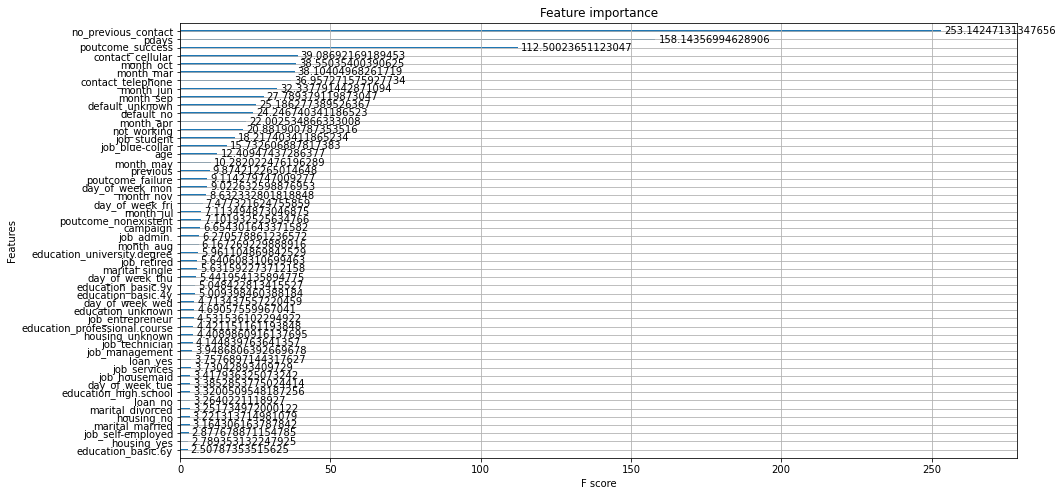

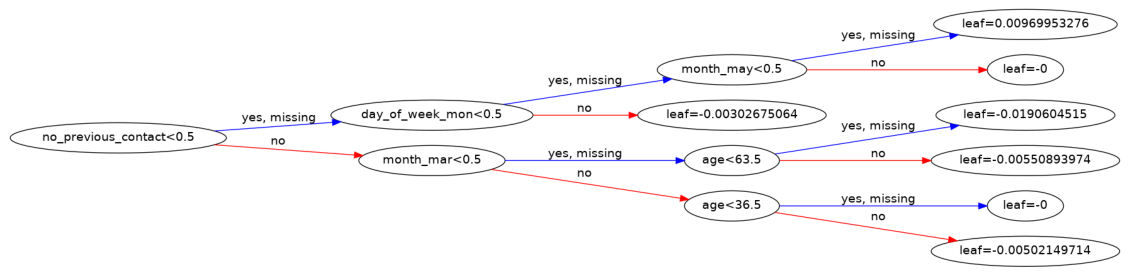

In [27]:
print('Feature Importances:')
print(best_model.feature_importances_)

import xgboost as xgb

feature_data = xgb.DMatrix(X_test)
best_model.get_booster().feature_names = feature_data.feature_names
best_model.get_booster().feature_types = feature_data.feature_types

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15, 8))
xgb.plot_importance(best_model, ax=ax, importance_type='gain')

!pip install graphviz

xgb.plot_tree(best_model, num_trees=0, rankdir='LR')

fig = plt.gcf()
fig.set_size_inches(20, 10)
plt.show()